In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [2]:
config = pd.Series({
    'path': os.path.abspath('../dades'),
    'file_type':'csv',
    'years':[2019],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [3]:
client = Client()
client

<Client: 'tcp://127.0.0.1:32915' processes=4 threads=16, memory=16.44 GB>

# Read data

In [4]:
%%time

data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

CPU times: user 208 ms, sys: 28.3 ms, total: 236 ms
Wall time: 228 ms


# config_year.year 

In [5]:
config_year = pd.Series({
    'path':config.path,
    'file_type':config.file_type,
    'year':2019,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [6]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [7]:
first_size = get_ddf_shape(data[config_year.year])

# Visualization 2019

In [8]:
%%time

data[config_year.year] = load_checkpoint(config_year)

# checkpoint reloaded.

checkpoint reloaded.
CPU times: user 18.4 ms, sys: 0 ns, total: 18.4 ms
Wall time: 17.2 ms


In [9]:
%%time

last_size = get_ddf_shape(data[config_year.year])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(last_size[0]-first_size[0]):02d} rows')
print(f'dropped {(last_size[1]-first_size[1]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed 58670 rows
dropped 03 columns
CPU times: user 367 ms, sys: 0 ns, total: 367 ms
Wall time: 2.26 s


In [10]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

25

In [11]:
%%time

nans = get_features_nans(data[config_year.year])

zeros = get_features_zero(data[config_year.year])

CPU times: user 1.43 s, sys: 51.3 ms, total: 1.48 s
Wall time: 8.68 s


In [12]:
nans

{}

In [13]:
zeros

{'num_bikes_available': 2.5852218116576604,
 'num_bikes_available_types.mechanical': 15.962736816249812,
 'num_bikes_available_types.ebike': 15.66128779626505,
 'num_docks_available': 0.5384432602148701,
 'is_charging_station': 2.2248802124493618e-05,
 'status': 99.94727033896496,
 'is_installed': 0.00017799041699594894,
 'is_renting': 0.058959325629908084,
 'is_returning': 0.058959325629908084,
 'dayofweek': 14.14434221861495,
 'hour': 4.427444876367857,
 'ctx0': 0.5384432602148701,
 'ctx1': 0.5376868009426373,
 'ctx2': 0.5355064183344369,
 'ctx3': 0.5335707725496059,
 'ctx4': 0.5315016339520281}

In [14]:
# nuniques = get_columns_nunique(data[config_year.year])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# timestamp                                  8700
# year                                          2
# month                                        12
# week                                         53
# dayofweek                                     7
# day                                          31
# dayofyear                                   366
# hour                                         24
# traffic                                    1741
# dtype: int64
    
uniques = get_columns_unique(data[config_year.year])

In [15]:
uniques

{'station_id': 0        1
 1      380
 2       28
 3      379
 4      378
       ... 
 505     86
 506    314
 507     74
 508     66
 509    431
 Name: station_id, Length: 510, dtype: int64,
 'num_bikes_available': 0       19.000000
 1       11.125000
 2       27.666667
 3       21.222222
 4       16.571429
           ...    
 5297     4.757576
 5298    24.176471
 5299     2.566667
 5300    52.708333
 5301    46.538462
 Name: num_bikes_available, Length: 5302, dtype: float64,
 'num_bikes_available_types.mechanical': 0       16.000000
 1       10.750000
 2       22.833333
 3       21.222222
 4       14.000000
           ...    
 4140    46.076923
 4141    23.588235
 4142     2.566667
 4143    45.846154
 4144    18.944444
 Name: num_bikes_available_types.mechanical, Length: 4145, dtype: float64,
 'num_bikes_available_types.ebike': 0        3.000000
 1        0.375000
 2        4.833333
 3        0.000000
 4        2.571429
           ...    
 2737    19.863636
 2738     3.133333
 2739  

## 2019 station_id

In [16]:
%%time

print(stats.describe(data[config_year.year].station_id))
data[config_year.year].station_id.describe().compute()

DescribeResult(nobs=4494624, minmax=(1, 519), mean=261.3721873064354, variance=22319.454886748445, skewness=-0.01250159333388424, kurtosis=-1.1882595031237102)
CPU times: user 876 ms, sys: 83.6 ms, total: 960 ms
Wall time: 3.99 s


count    4.494624e+06
mean     2.613722e+02
std      1.493970e+02
min      1.000000e+00
25%      1.370000e+02
50%      2.720000e+02
75%      3.950000e+02
max      5.190000e+02
Name: station_id, dtype: float64

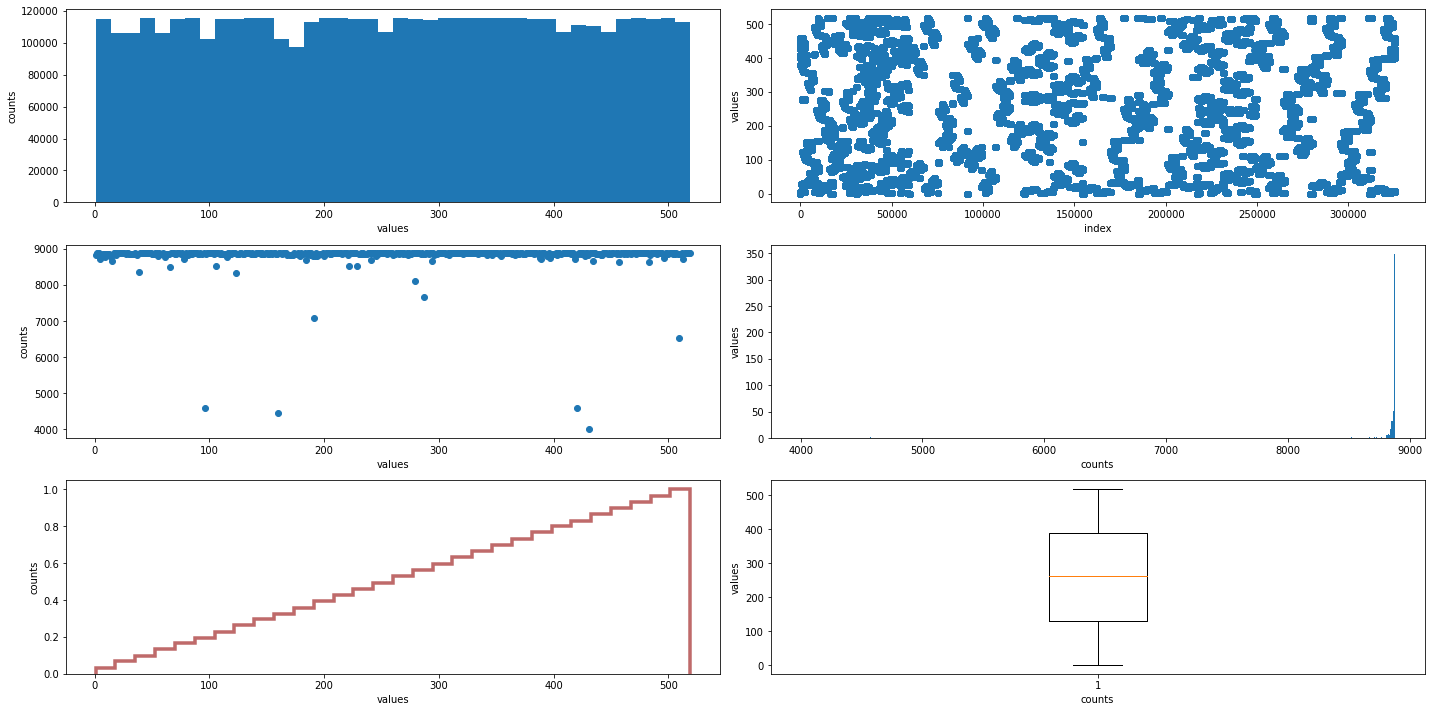

CPU times: user 7.11 s, sys: 1.13 s, total: 8.23 s
Wall time: 8.63 s


In [17]:
%%time

show_counts(data[config_year.year].station_id.compute())

value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.01 s, sys: 92.7 ms, total: 2.1 s
Wall time: 11.3 s


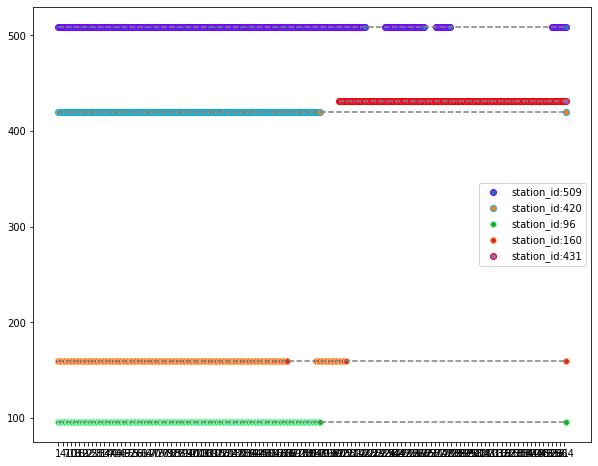

In [18]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofyear', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=np.arange(uniques['dayofyear'].min(),uniques['dayofyear'].max(), 3.0),
    figsize=(10,8)
)

## 2019 num_bikes_available

In [19]:
%%time

print(stats.describe(data[config_year.year].num_bikes_available))
data[config_year.year].num_bikes_available.describe().compute()

DescribeResult(nobs=4494624, minmax=(0.0, 54.0), mean=9.351510117179094, variance=56.73349884495573, skewness=0.9737984624129264, kurtosis=1.0782040315029695)
CPU times: user 850 ms, sys: 125 ms, total: 975 ms
Wall time: 4.03 s


count    4.494624e+06
mean     9.351510e+00
std      7.532164e+00
min      0.000000e+00
25%      4.416667e+00
50%      9.666667e+00
75%      1.566667e+01
max      5.400000e+01
Name: num_bikes_available, dtype: float64

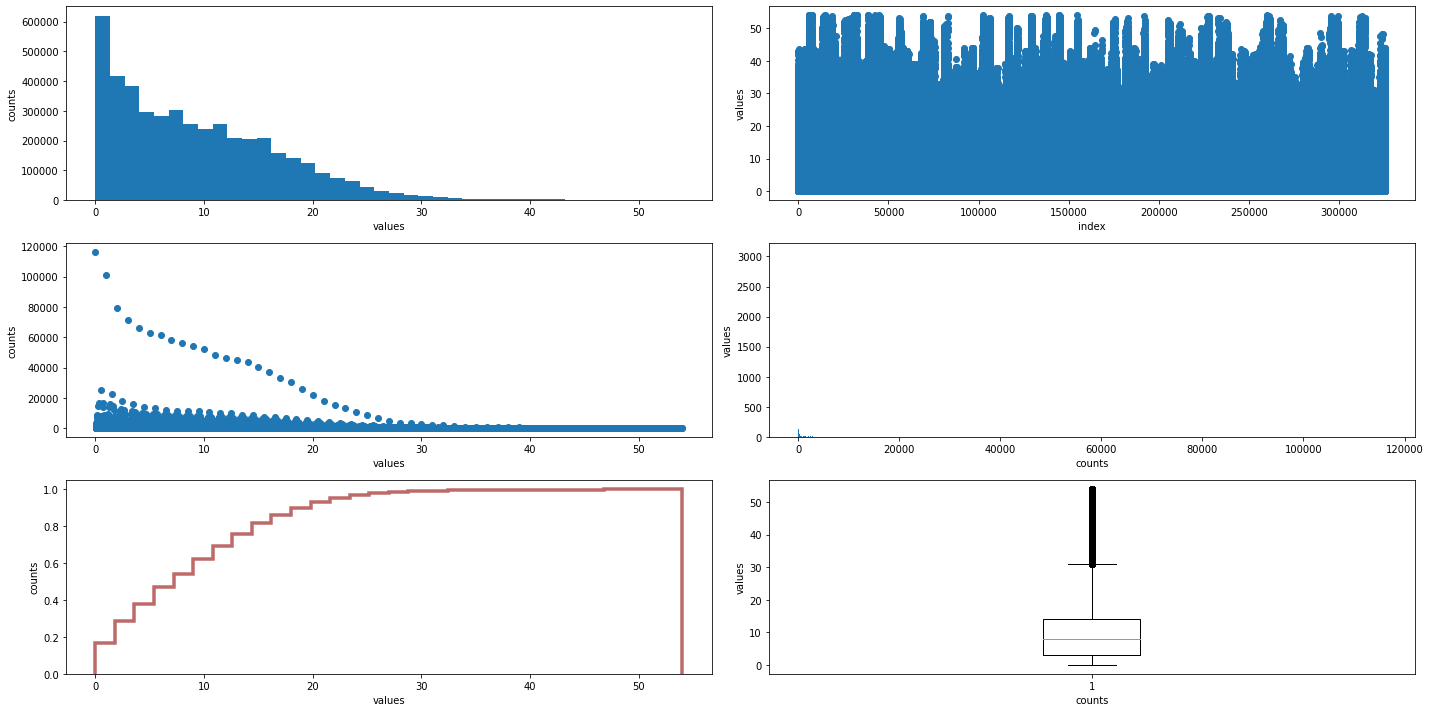

CPU times: user 12.4 s, sys: 1.66 s, total: 14 s
Wall time: 15.1 s


In [20]:
%%time

show_counts(data[config_year.year].num_bikes_available.compute())

350
value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.22 s, sys: 201 ms, total: 2.42 s
Wall time: 11.7 s


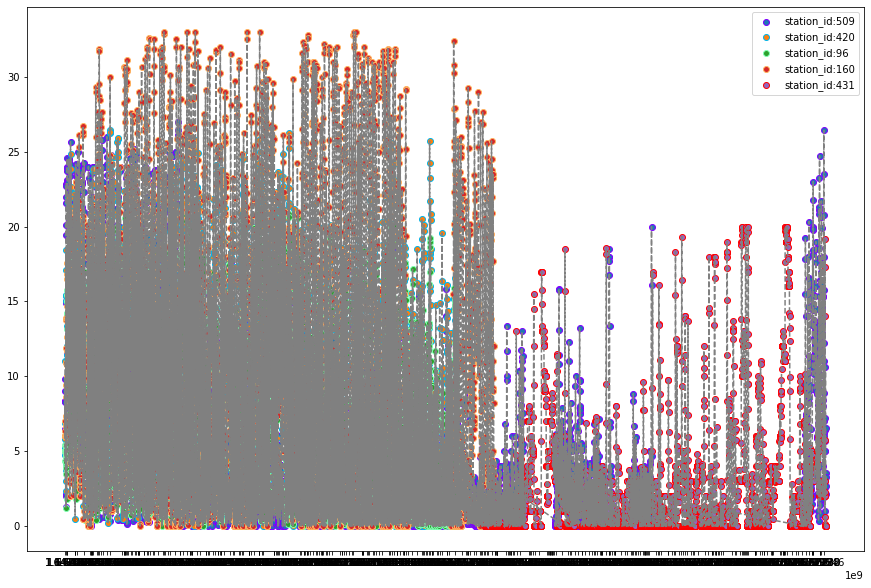

In [21]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.7 s, sys: 162 ms, total: 2.87 s
Wall time: 13 s


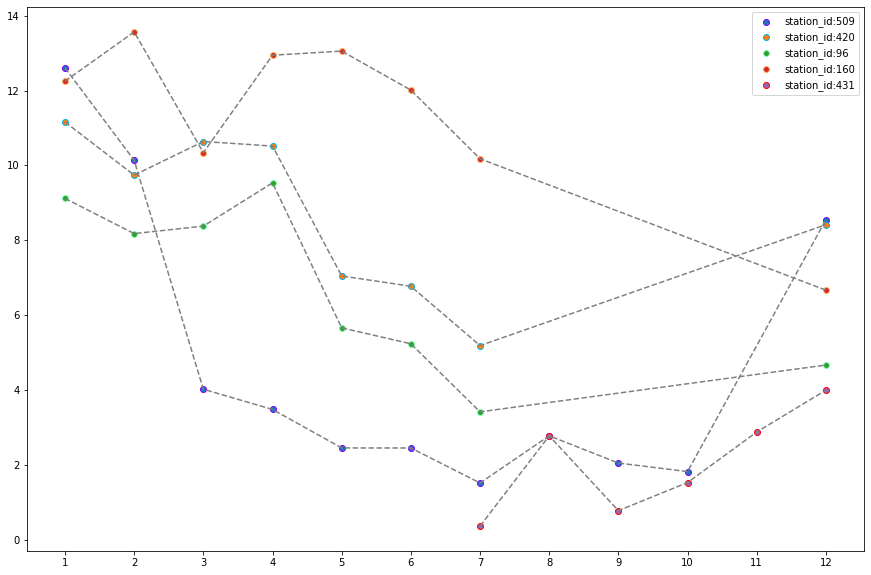

In [22]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.99 s, sys: 212 ms, total: 2.2 s
Wall time: 12.2 s


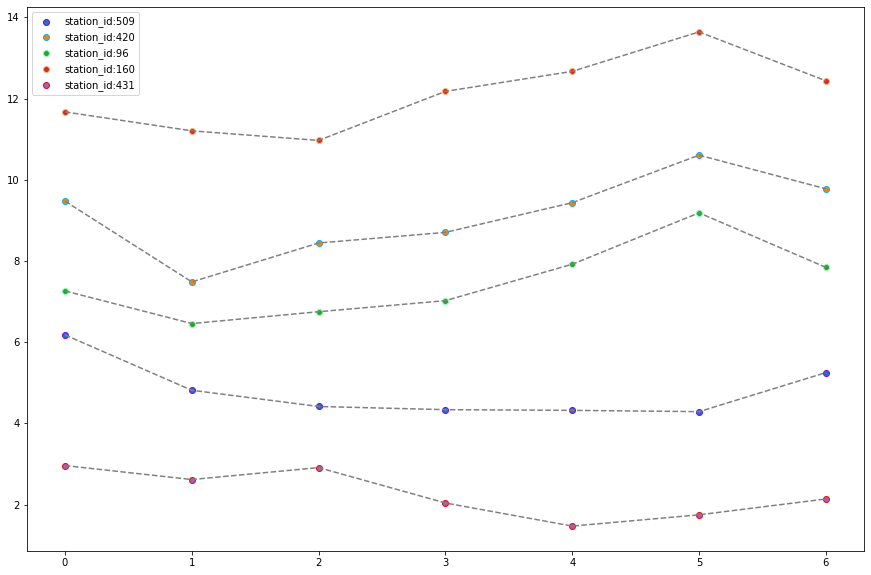

In [23]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.42 s, sys: 199 ms, total: 2.62 s
Wall time: 12.9 s


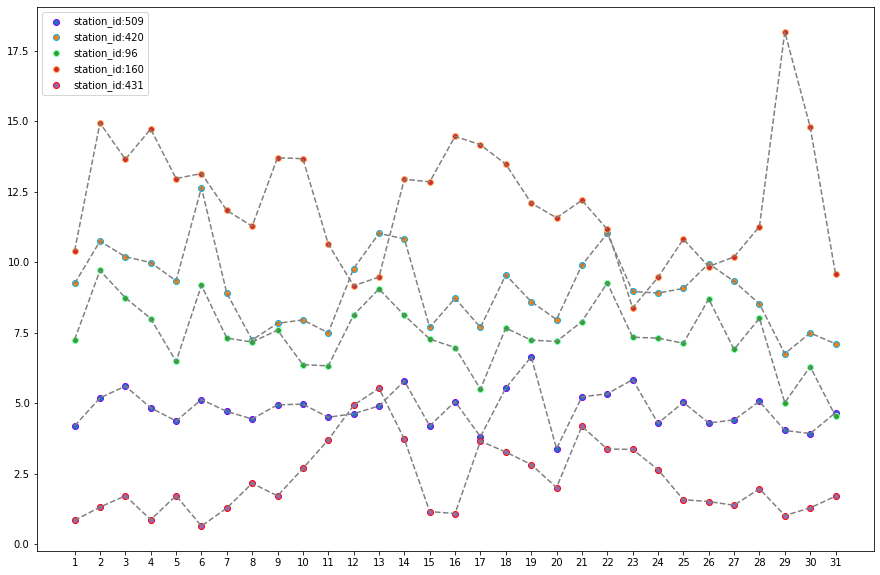

In [24]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 680, 'mean': 680.0, 'median': 680.0, 'std': nan, 'min': 680}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 757, 'mean': 757.0, 'median': 757.0, 'std': nan, 'min': 757}


  0%|          | 0/1 [00:00<?, ?it/s]

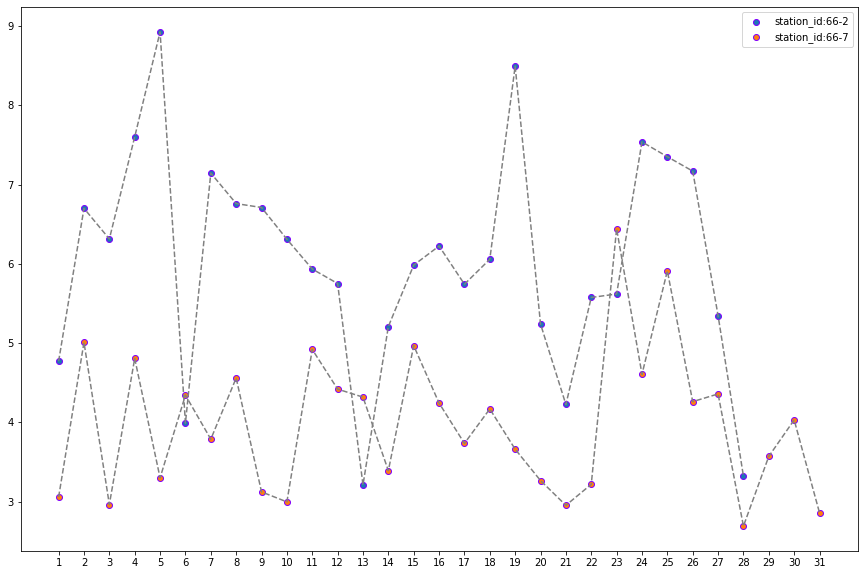

CPU times: user 1.66 s, sys: 114 ms, total: 1.78 s
Wall time: 8.4 s


In [25]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 680, 'mean': 680.0, 'median': 680.0, 'std': nan, 'min': 680}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 758, 'mean': 758.0, 'median': 758.0, 'std': nan, 'min': 758}


  0%|          | 0/1 [00:00<?, ?it/s]

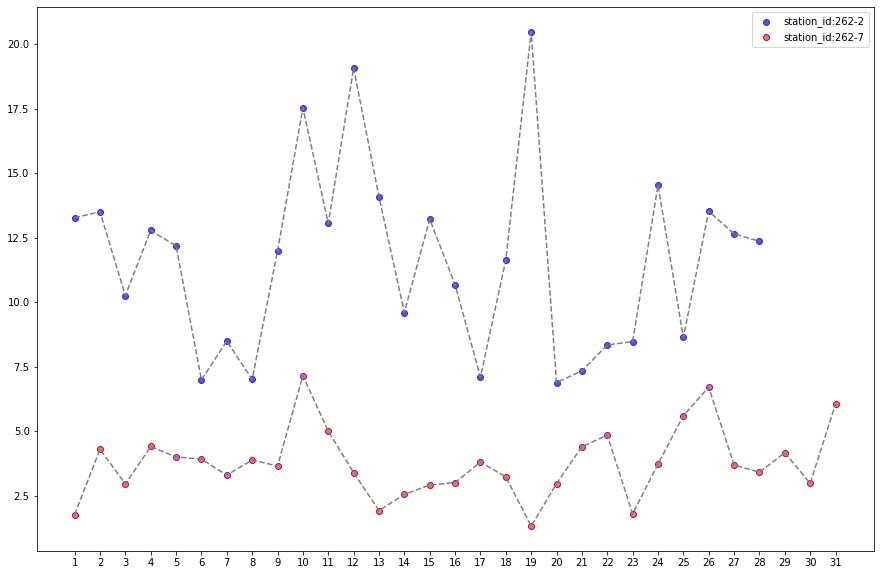

CPU times: user 1.75 s, sys: 111 ms, total: 1.86 s
Wall time: 8.94 s


In [26]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.87 s, sys: 207 ms, total: 3.08 s
Wall time: 13.7 s


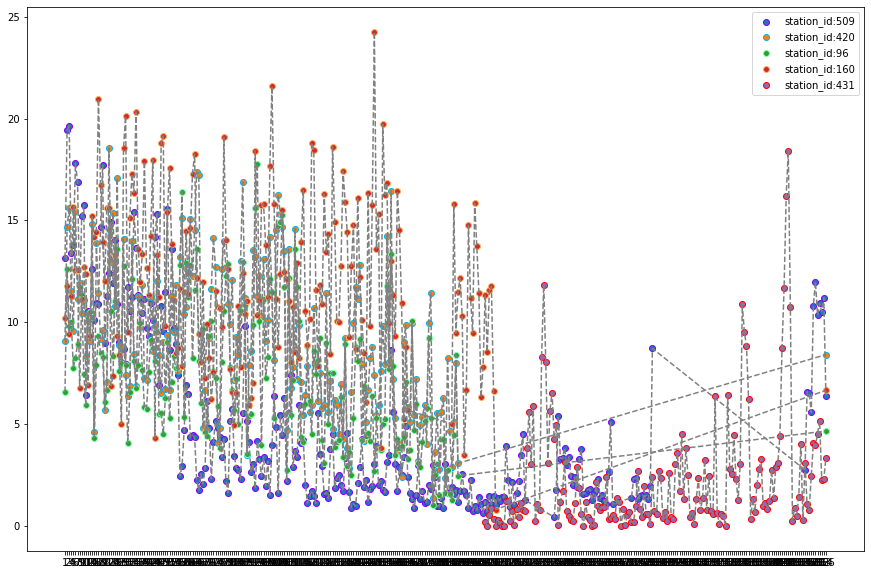

In [27]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.04 s, sys: 156 ms, total: 2.2 s
Wall time: 11.7 s


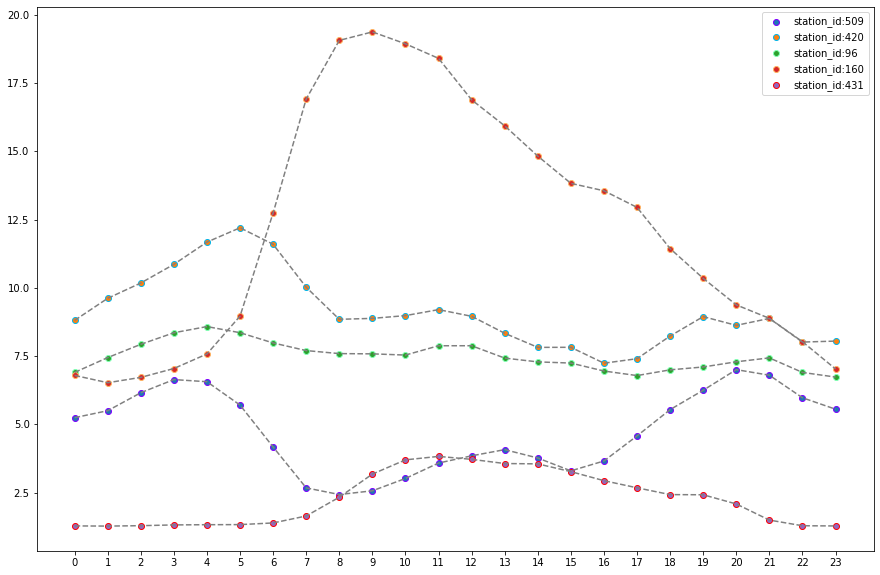

In [28]:
%%time

scatter_columns(data[config_year.year], 'hour', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 24, 'mean': 24.0, 'median': 24.0, 'std': 0.0, 'min': 24}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.89 s, sys: 121 ms, total: 2.01 s
Wall time: 11 s


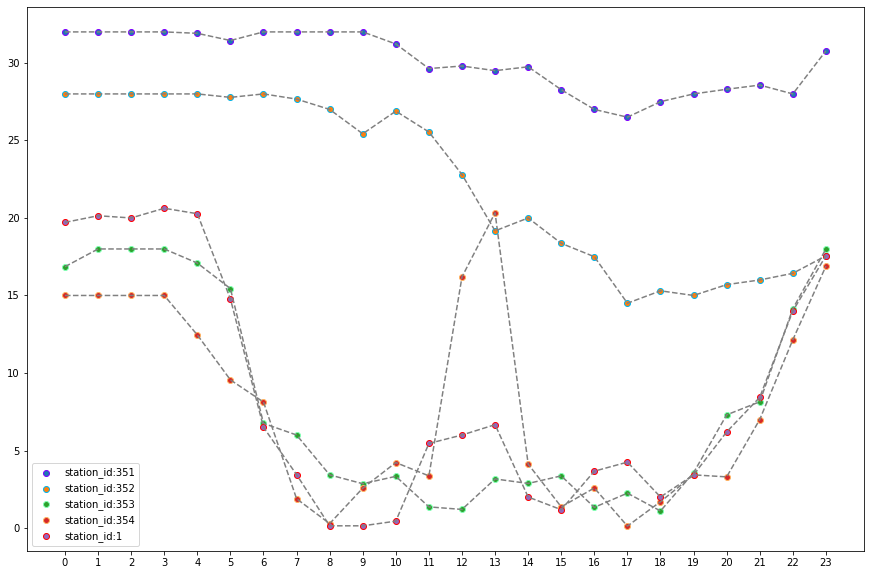

In [29]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 24, 'mean': 23.956777996070727, 'median': 24.0, 'std': 0.41868070801376256, 'min': 19}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.92 s, sys: 171 ms, total: 2.09 s
Wall time: 11 s


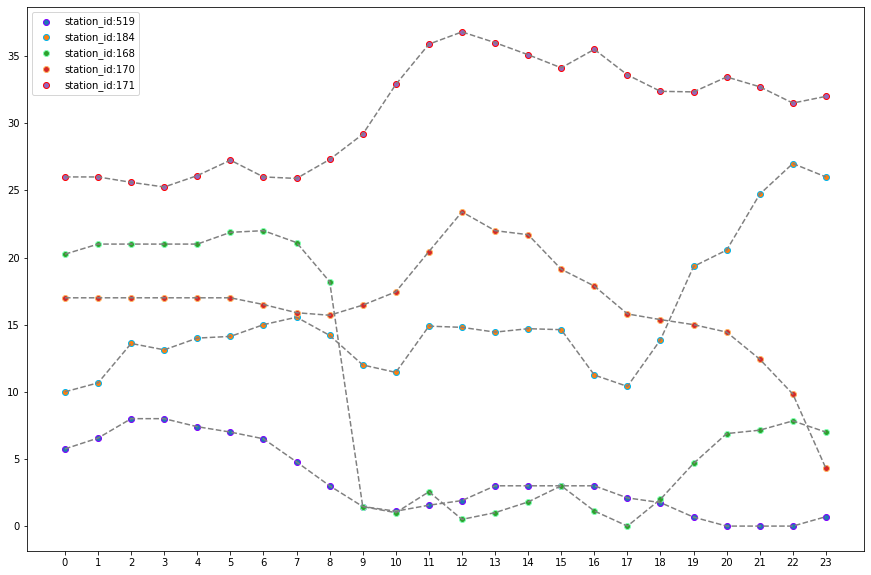

In [30]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 1204, 'mean': 1204.0, 'median': 1204.0, 'std': nan, 'min': 1204}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1226, 'mean': 1226.0, 'median': 1226.0, 'std': nan, 'min': 1226}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1214, 'mean': 1214.0, 'median': 1214.0, 'std': nan, 'min': 1214}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1228, 'mean': 1228.0, 'median': 1228.0, 'std': nan, 'min': 1228}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1221, 'mean': 1221.0, 'median': 1221.0, 'std': nan, 'min': 1221}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1213, 'mean': 1213.0, 'median': 1213.0, 'std': nan, 'min': 1213}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1190, 'mean': 1190.0, 'median': 1190.0, 'std': nan, 'min': 1190}


  0%|          | 0/1 [00:00<?, ?it/s]

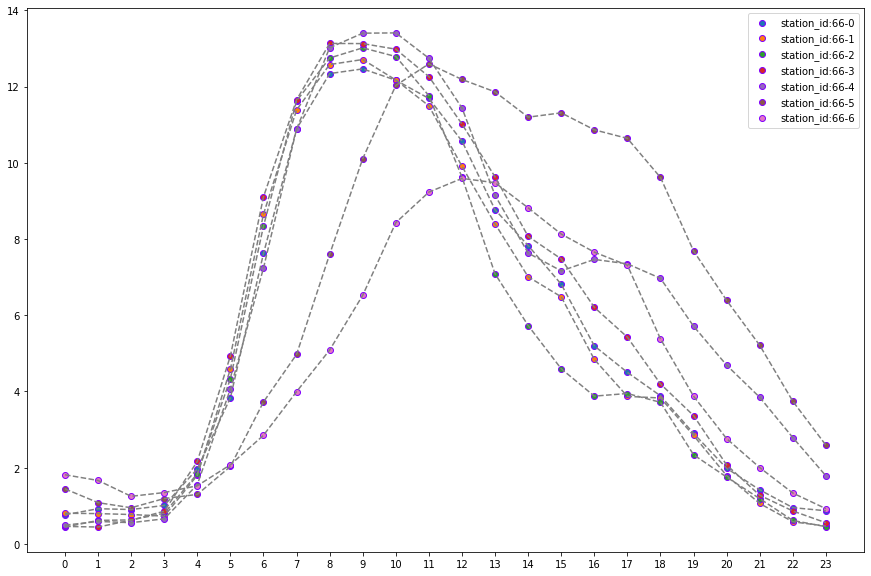

CPU times: user 4.97 s, sys: 477 ms, total: 5.44 s
Wall time: 28.2 s


In [31]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 1246, 'mean': 1246.0, 'median': 1246.0, 'std': nan, 'min': 1246}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1265, 'mean': 1265.0, 'median': 1265.0, 'std': nan, 'min': 1265}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1262, 'mean': 1262.0, 'median': 1262.0, 'std': nan, 'min': 1262}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1279, 'mean': 1279.0, 'median': 1279.0, 'std': nan, 'min': 1279}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1271, 'mean': 1271.0, 'median': 1271.0, 'std': nan, 'min': 1271}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1285, 'mean': 1285.0, 'median': 1285.0, 'std': nan, 'min': 1285}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1262, 'mean': 1262.0, 'median': 1262.0, 'std': nan, 'min': 1262}


  0%|          | 0/1 [00:00<?, ?it/s]

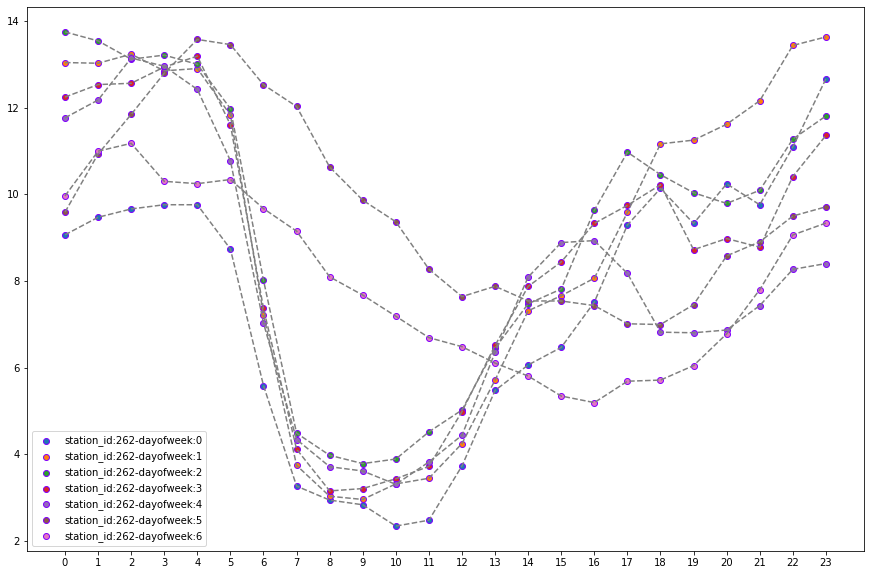

CPU times: user 4.84 s, sys: 453 ms, total: 5.29 s
Wall time: 27.6 s


In [32]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

## 2019 is_charging_station

In [33]:
%%time

print(stats.describe(data[config_year.year].is_charging_station))
data[config_year.year].is_charging_station.describe().compute()

DescribeResult(nobs=4494624, minmax=(0, 1), mean=0.9999997775119788, variance=2.2248802124493432e-07, skewness=-2120.0521220008377, kurtosis=4494619.000000296)
CPU times: user 1.02 s, sys: 101 ms, total: 1.12 s
Wall time: 4.25 s


count    4.494624e+06
mean     9.999998e-01
std      4.716864e-04
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_charging_station, dtype: float64

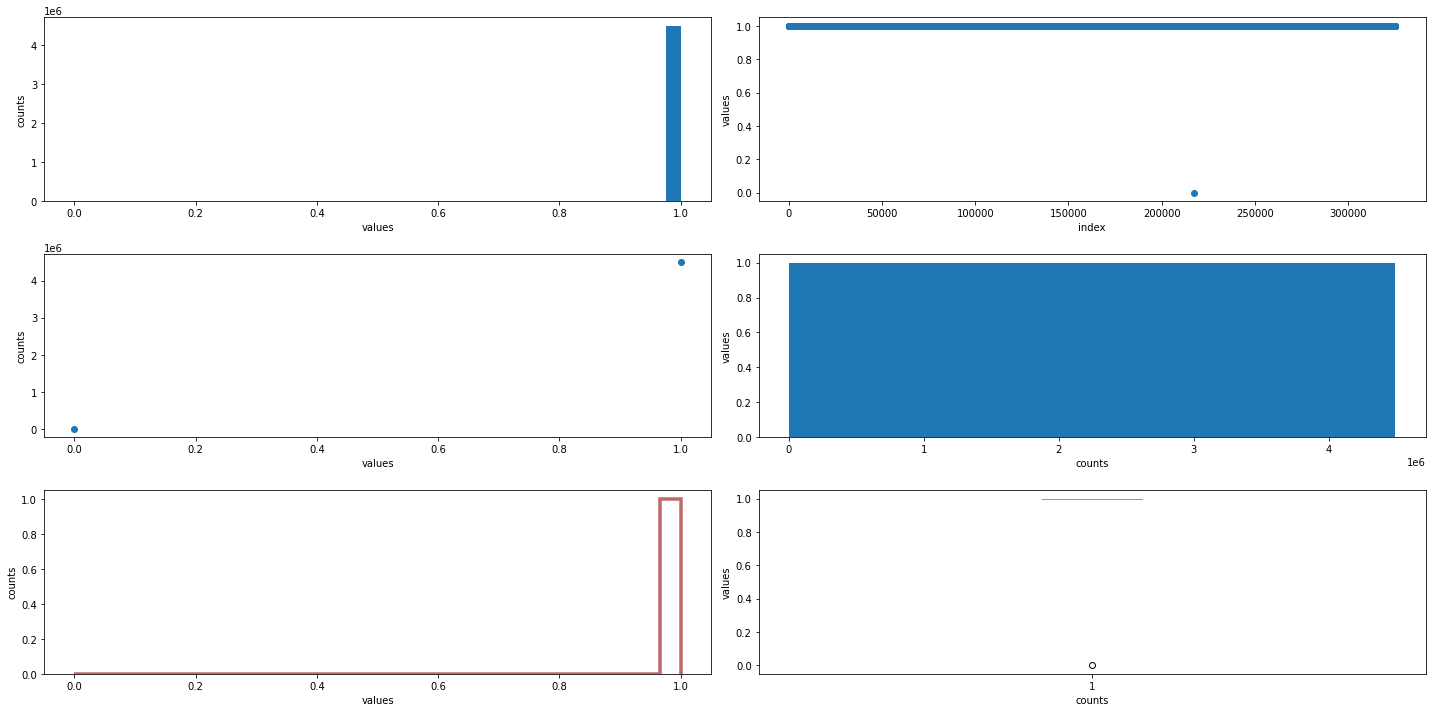

CPU times: user 6.88 s, sys: 388 ms, total: 7.26 s
Wall time: 8.53 s


In [34]:
%%time

show_counts(data[config_year.year].is_charging_station.compute())

## 2019 status

In [35]:
%%time

print(stats.describe(data[config_year.year].status))
data[config_year.year].status.describe().compute()

DescribeResult(nobs=4494624, minmax=(0, 3), mean=0.0006154018667634935, variance=0.0007925687645963961, skewness=51.5657509199609, kurtosis=2988.912446554348)
CPU times: user 1.05 s, sys: 182 ms, total: 1.23 s
Wall time: 4.88 s


count    4.494624e+06
mean     6.154019e-04
std      2.815260e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+00
Name: status, dtype: float64

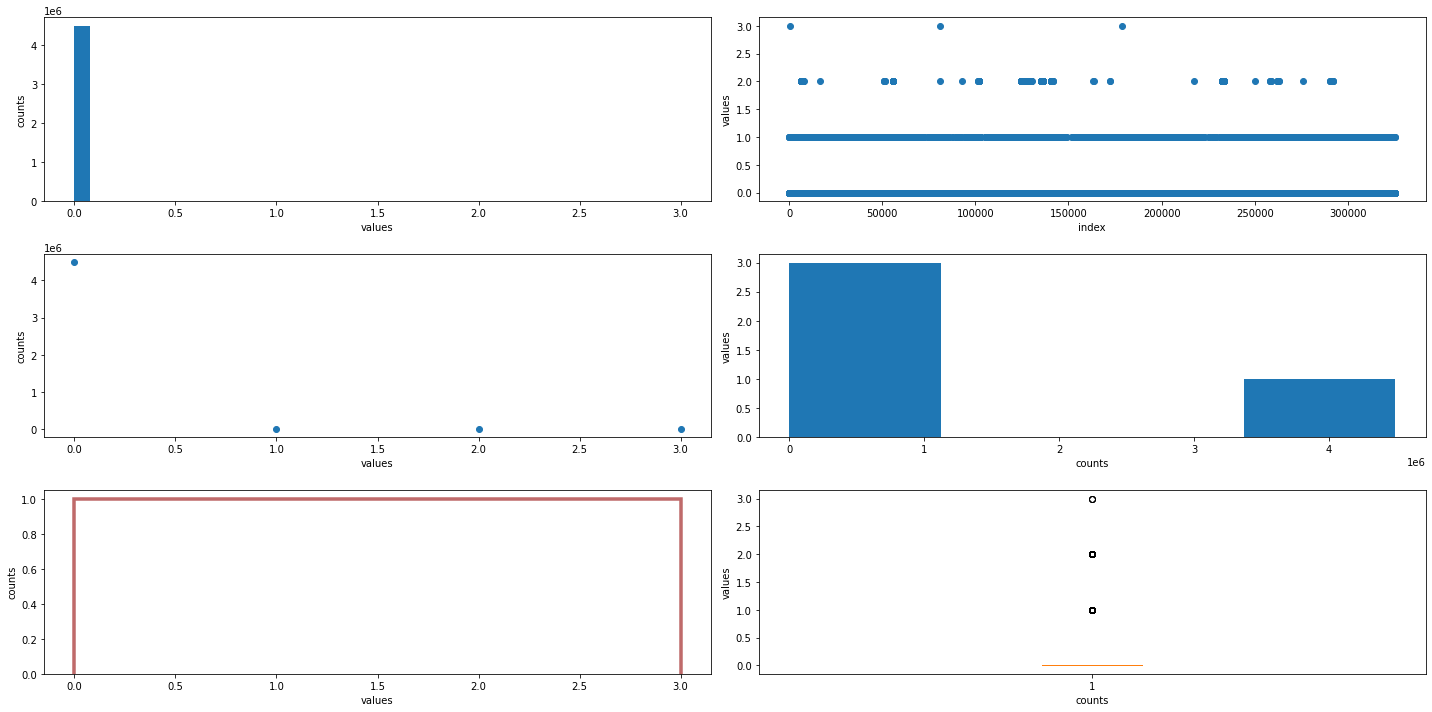

CPU times: user 7.36 s, sys: 503 ms, total: 7.86 s
Wall time: 9.44 s


In [36]:
%%time

show_counts(data[config_year.year].status.compute())

## 2019 is_installed

In [37]:
%%time

print(stats.describe(data[config_year.year].is_installed))
data[config_year.year].is_installed.describe().compute()

DescribeResult(nobs=4494624, minmax=(0, 1), mean=0.9999982200958301, variance=1.7799013979073419e-06, skewness=-749.5498649201478, kurtosis=561823.000001801)
CPU times: user 1.38 s, sys: 144 ms, total: 1.52 s
Wall time: 5.64 s


count    4.494624e+06
mean     9.999982e-01
std      1.334129e-03
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_installed, dtype: float64

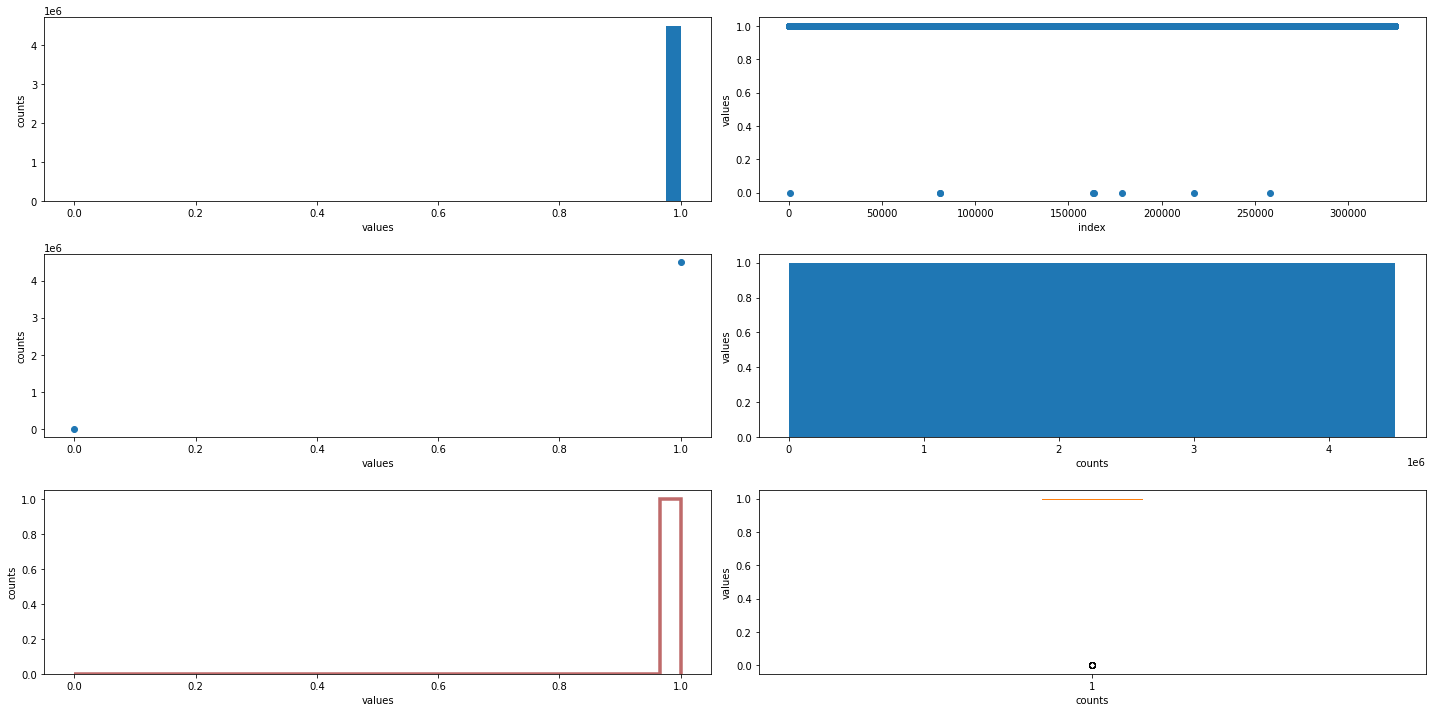

CPU times: user 7.98 s, sys: 502 ms, total: 8.48 s
Wall time: 10.2 s


In [38]:
%%time

show_counts(data[config_year.year].is_installed.compute())

## 2019 is_renting

In [39]:
%%time

print(stats.describe(data[config_year.year].is_renting))
data[config_year.year].is_renting.describe().compute()

DescribeResult(nobs=4494624, minmax=(0, 1), mean=0.999410406743701, variance=0.0005892457671913311, skewness=-41.14711555191882, kurtosis=1691.0851182429692)
CPU times: user 1.28 s, sys: 171 ms, total: 1.45 s
Wall time: 4.93 s


count    4.494624e+06
mean     9.994104e-01
std      2.427439e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_renting, dtype: float64

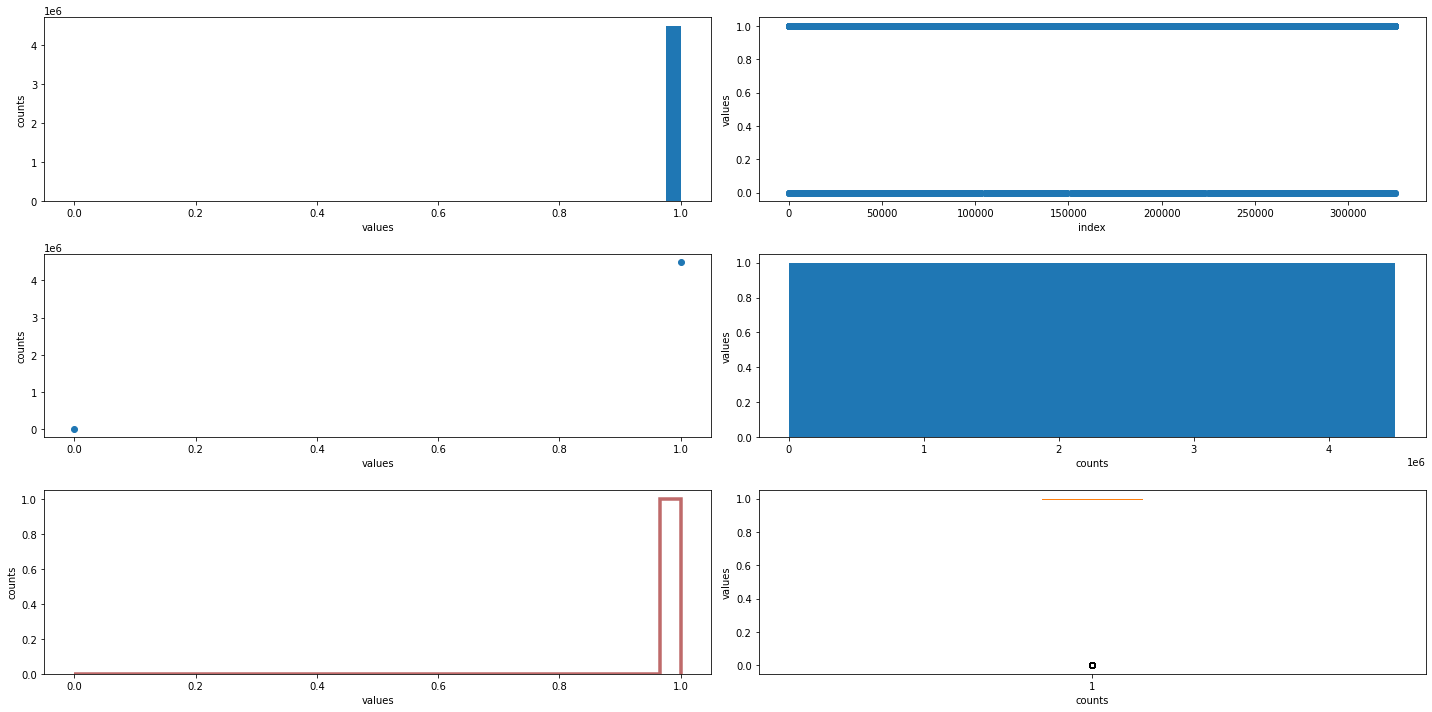

CPU times: user 5.83 s, sys: 366 ms, total: 6.19 s
Wall time: 7.43 s


In [40]:
%%time

show_counts(data[config_year.year].is_renting.compute())

## 2019 is_returning

In [41]:
%%time

print(stats.describe(data[config_year.year].is_returning))
data[config_year.year].is_returning.describe().compute()

DescribeResult(nobs=4494624, minmax=(0, 1), mean=0.999410406743701, variance=0.0005892457671913311, skewness=-41.14711555191882, kurtosis=1691.0851182429692)
CPU times: user 860 ms, sys: 112 ms, total: 971 ms
Wall time: 3.82 s


count    4.494624e+06
mean     9.994104e-01
std      2.427439e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_returning, dtype: float64

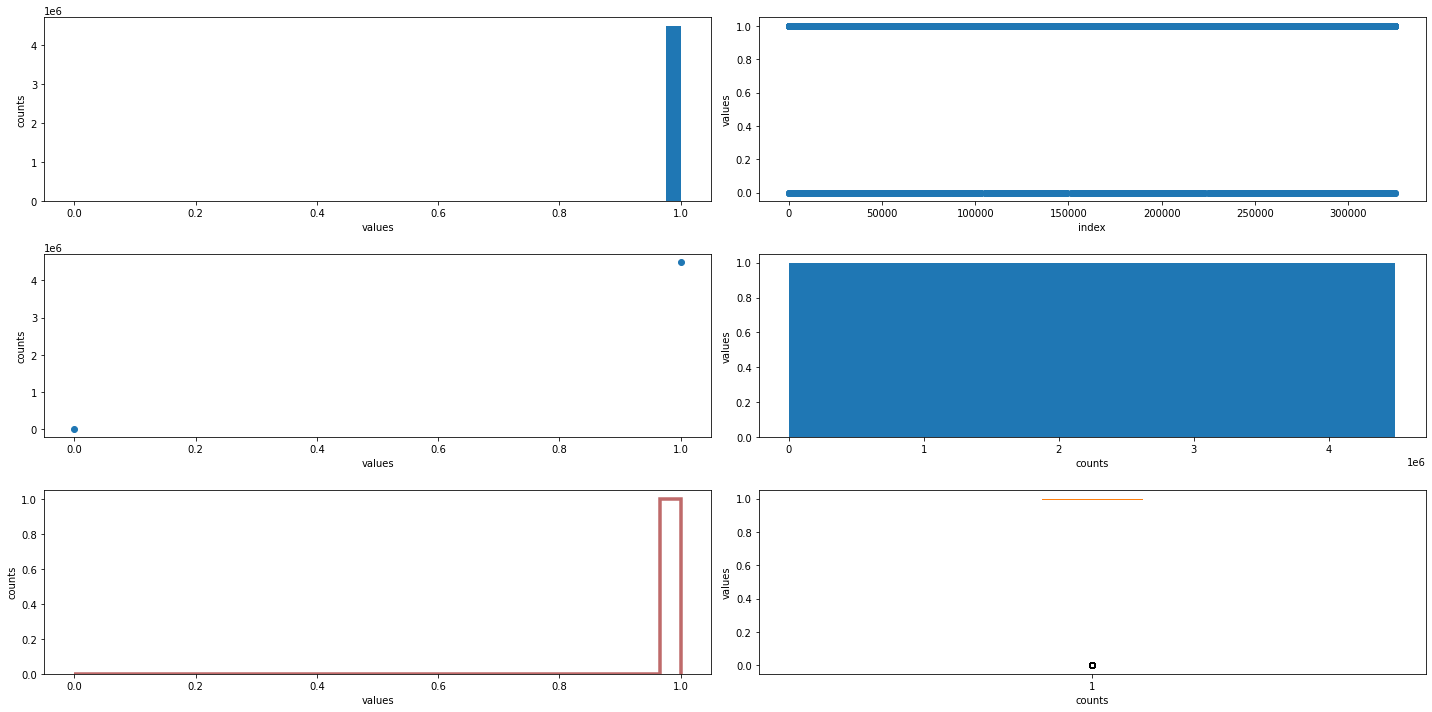

CPU times: user 6.15 s, sys: 376 ms, total: 6.52 s
Wall time: 7.94 s


In [42]:
%%time

show_counts(data[config_year.year].is_returning.compute())

## 2019 ctx0

In [43]:
%%time

print(stats.describe(data[config_year.year].ctx0))
data[config_year.year].ctx0.describe().compute()

DescribeResult(nobs=4494624, minmax=(0.0, 0.9999999999999998), mean=0.5860363887031753, variance=0.06829671772412879, skewness=-0.46167300259486616, kurtosis=-0.7699239128297553)
CPU times: user 855 ms, sys: 165 ms, total: 1.02 s
Wall time: 4.15 s


count    4.494624e+06
mean     5.860364e-01
std      2.613364e-01
min      0.000000e+00
25%      4.027778e-01
50%      6.296296e-01
75%      8.055556e-01
max      1.000000e+00
Name: ctx0, dtype: float64

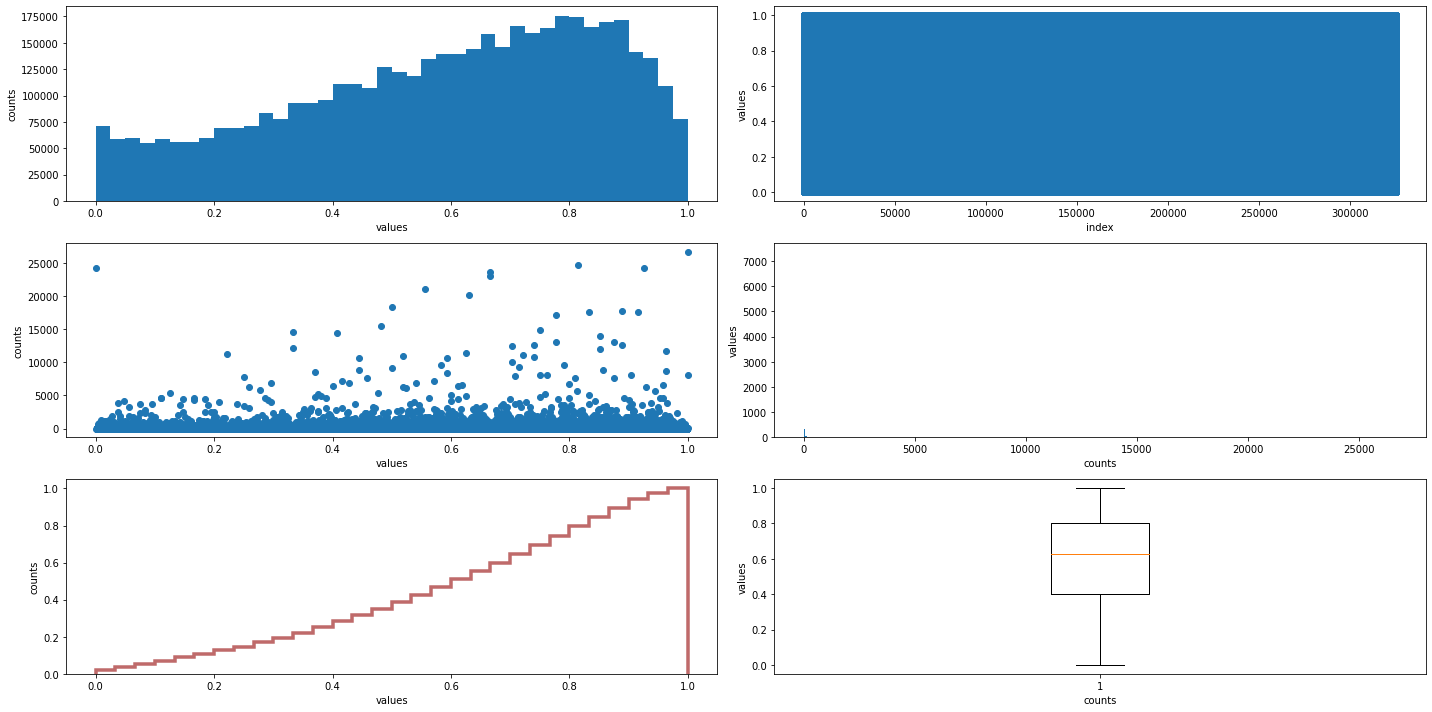

CPU times: user 1min 6s, sys: 10.4 s, total: 1min 16s
Wall time: 1min 16s


In [44]:
%%time

show_counts(data[config_year.year].ctx0.compute())

350
value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 840 ms, sys: 147 ms, total: 986 ms
Wall time: 4.05 s


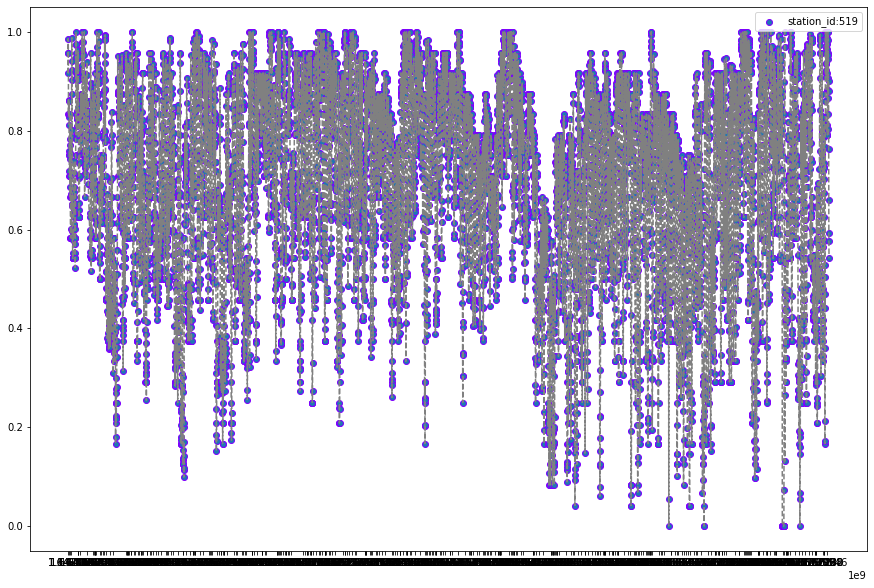

In [45]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=1
)


value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 5.56 s, sys: 258 ms, total: 5.82 s
Wall time: 15.4 s


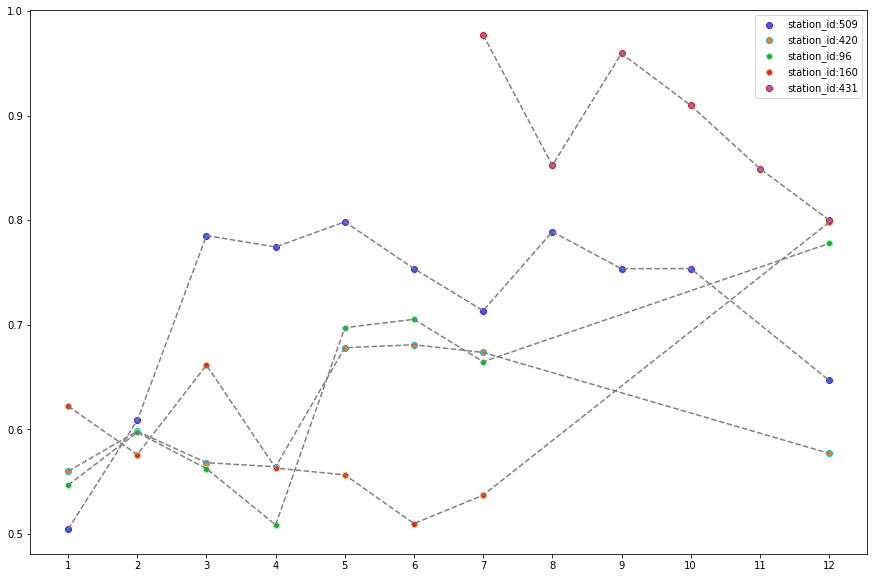

In [46]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.98 s, sys: 185 ms, total: 2.17 s
Wall time: 11.6 s


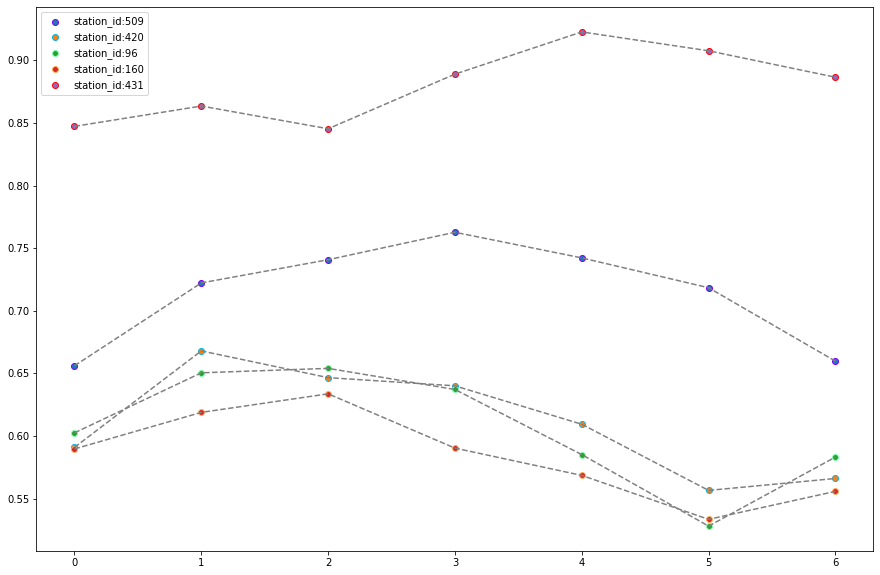

In [47]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.85 s, sys: 191 ms, total: 2.04 s
Wall time: 11.2 s


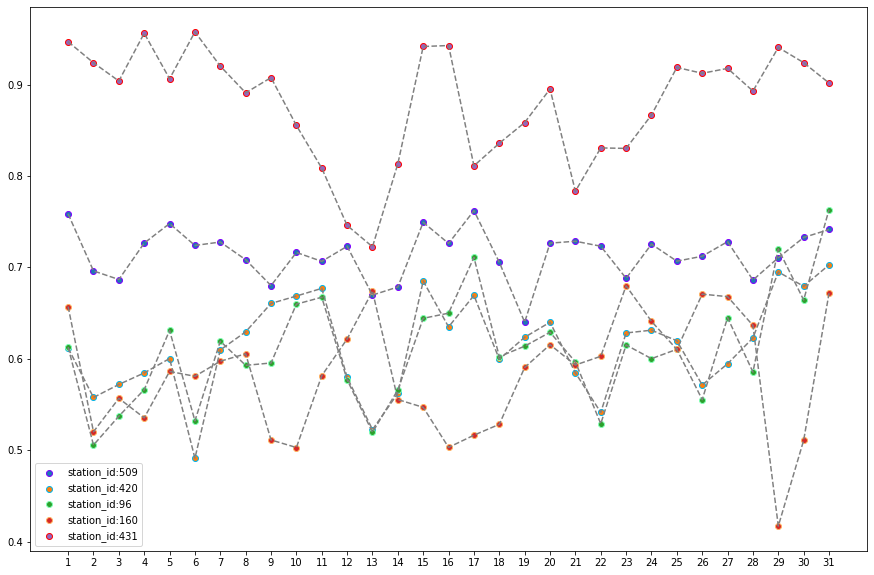

In [48]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 680, 'mean': 680.0, 'median': 680.0, 'std': nan, 'min': 680}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 757, 'mean': 757.0, 'median': 757.0, 'std': nan, 'min': 757}


  0%|          | 0/1 [00:00<?, ?it/s]

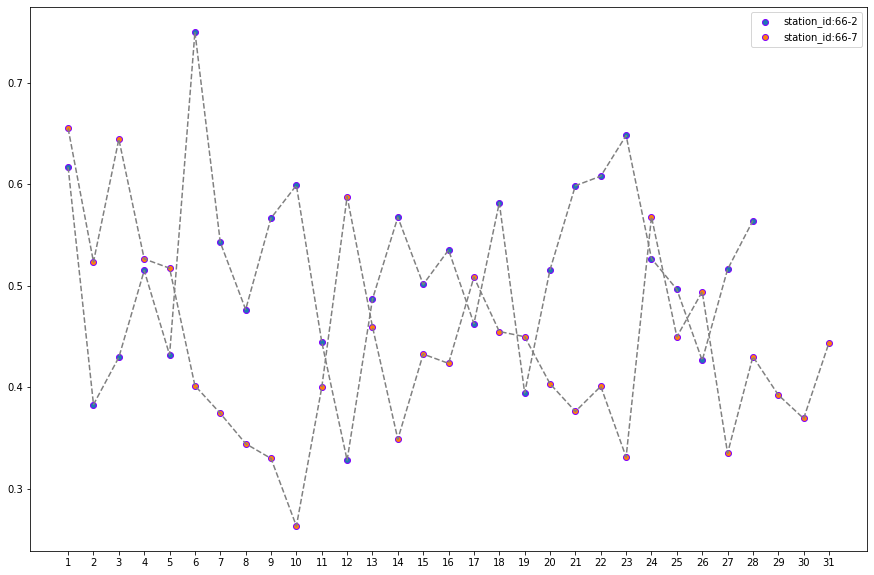

CPU times: user 1.43 s, sys: 205 ms, total: 1.63 s
Wall time: 8.18 s


In [49]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 680, 'mean': 680.0, 'median': 680.0, 'std': nan, 'min': 680}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 758, 'mean': 758.0, 'median': 758.0, 'std': nan, 'min': 758}


  0%|          | 0/1 [00:00<?, ?it/s]

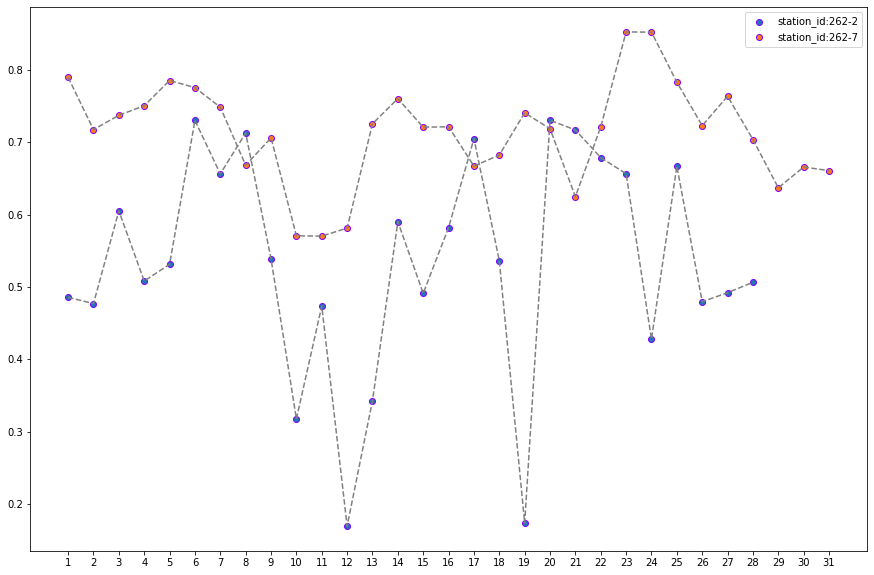

CPU times: user 1.43 s, sys: 212 ms, total: 1.64 s
Wall time: 7.94 s


In [50]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.36 s, sys: 203 ms, total: 2.56 s
Wall time: 11.9 s


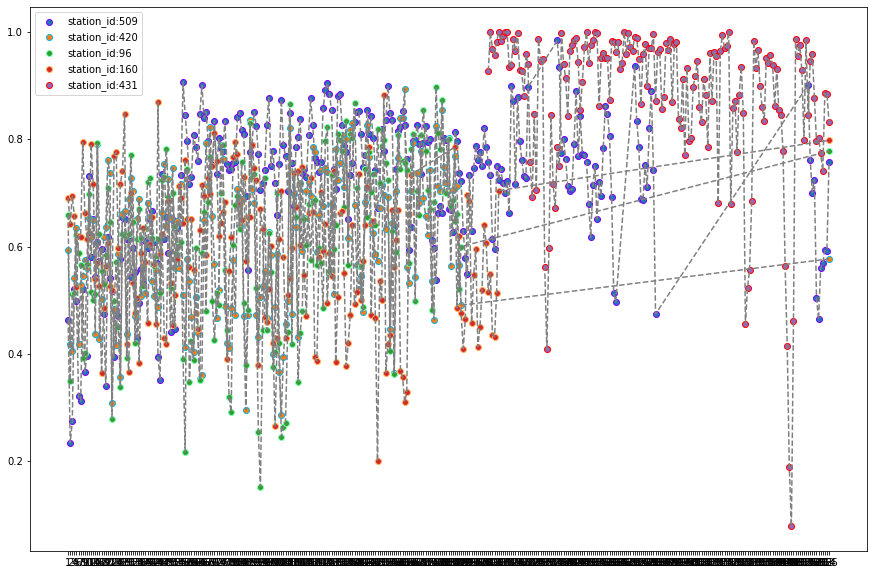

In [51]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8879, 'mean': 8812.988235294117, 'median': 8878.0, 'std': 422.5717035664278, 'min': 3998}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.19 s, sys: 208 ms, total: 2.39 s
Wall time: 12.2 s


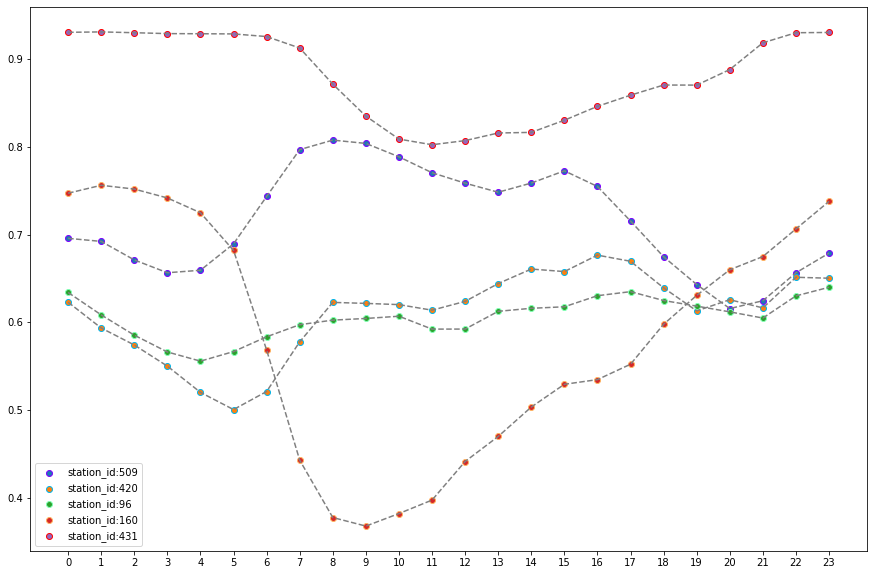

In [52]:
%%time

scatter_columns(data[config_year.year], 'hour', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 24, 'mean': 24.0, 'median': 24.0, 'std': 0.0, 'min': 24}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.33 s, sys: 190 ms, total: 2.52 s
Wall time: 12.8 s


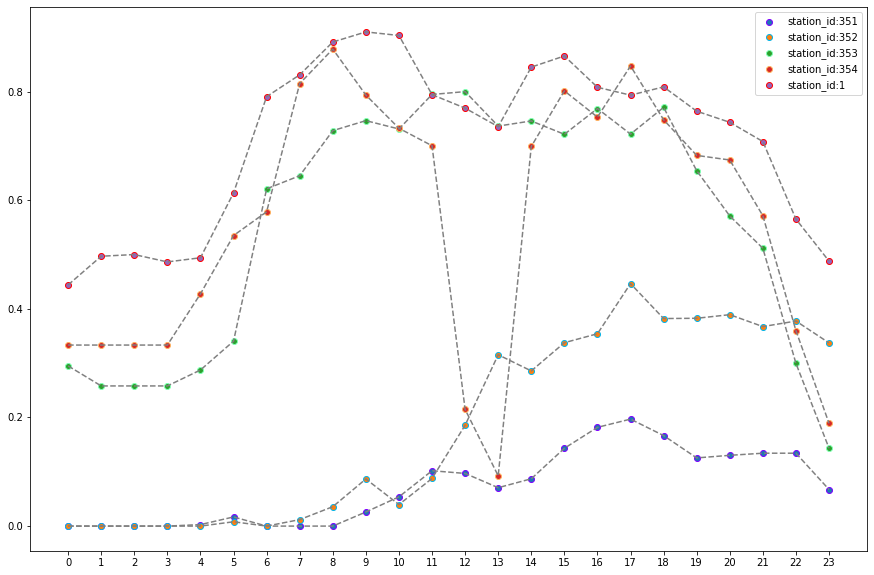

In [53]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 24, 'mean': 23.956777996070727, 'median': 24.0, 'std': 0.41868070801376256, 'min': 19}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.28 s, sys: 232 ms, total: 2.51 s
Wall time: 12.8 s


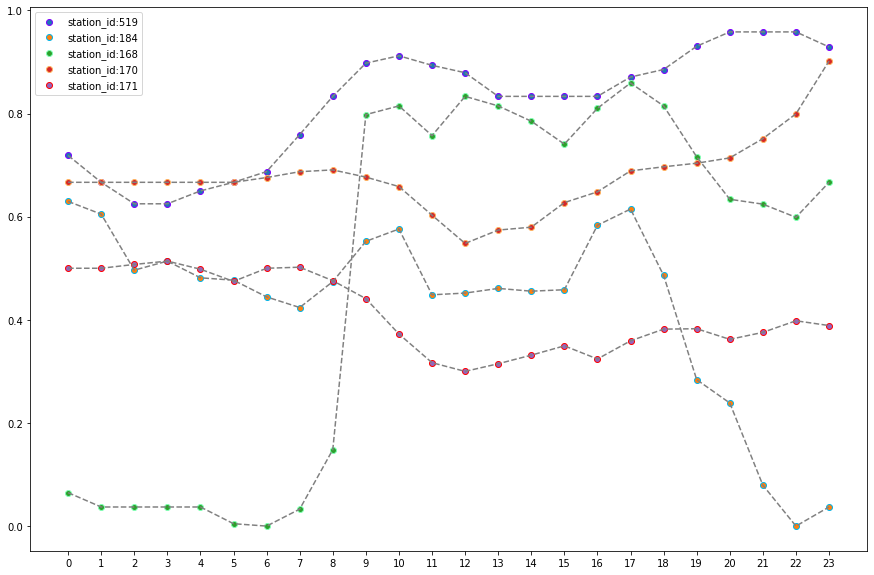

In [54]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 1204, 'mean': 1204.0, 'median': 1204.0, 'std': nan, 'min': 1204}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1226, 'mean': 1226.0, 'median': 1226.0, 'std': nan, 'min': 1226}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1214, 'mean': 1214.0, 'median': 1214.0, 'std': nan, 'min': 1214}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1228, 'mean': 1228.0, 'median': 1228.0, 'std': nan, 'min': 1228}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1221, 'mean': 1221.0, 'median': 1221.0, 'std': nan, 'min': 1221}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1213, 'mean': 1213.0, 'median': 1213.0, 'std': nan, 'min': 1213}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1190, 'mean': 1190.0, 'median': 1190.0, 'std': nan, 'min': 1190}


  0%|          | 0/1 [00:00<?, ?it/s]

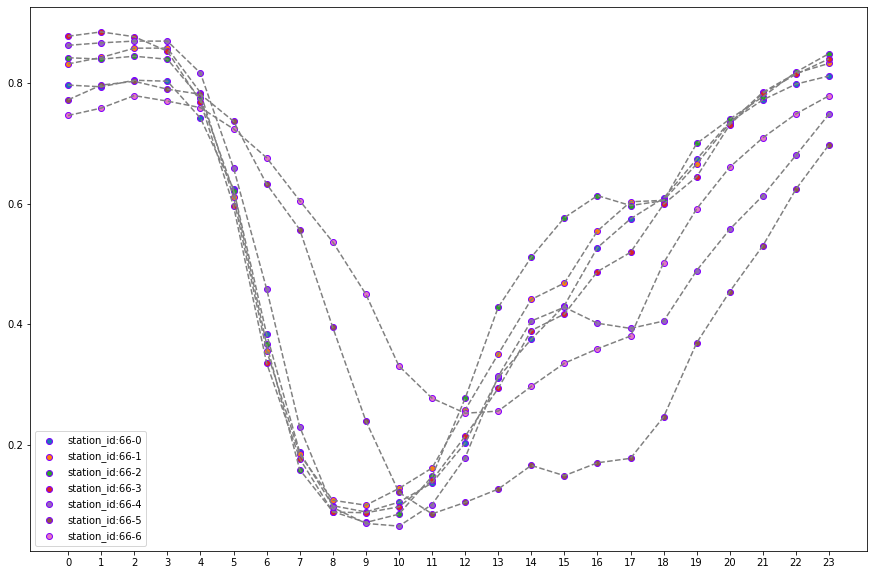

CPU times: user 5.13 s, sys: 680 ms, total: 5.81 s
Wall time: 29.6 s


In [55]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 1246, 'mean': 1246.0, 'median': 1246.0, 'std': nan, 'min': 1246}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1265, 'mean': 1265.0, 'median': 1265.0, 'std': nan, 'min': 1265}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1262, 'mean': 1262.0, 'median': 1262.0, 'std': nan, 'min': 1262}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1279, 'mean': 1279.0, 'median': 1279.0, 'std': nan, 'min': 1279}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1271, 'mean': 1271.0, 'median': 1271.0, 'std': nan, 'min': 1271}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1285, 'mean': 1285.0, 'median': 1285.0, 'std': nan, 'min': 1285}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1262, 'mean': 1262.0, 'median': 1262.0, 'std': nan, 'min': 1262}


  0%|          | 0/1 [00:00<?, ?it/s]

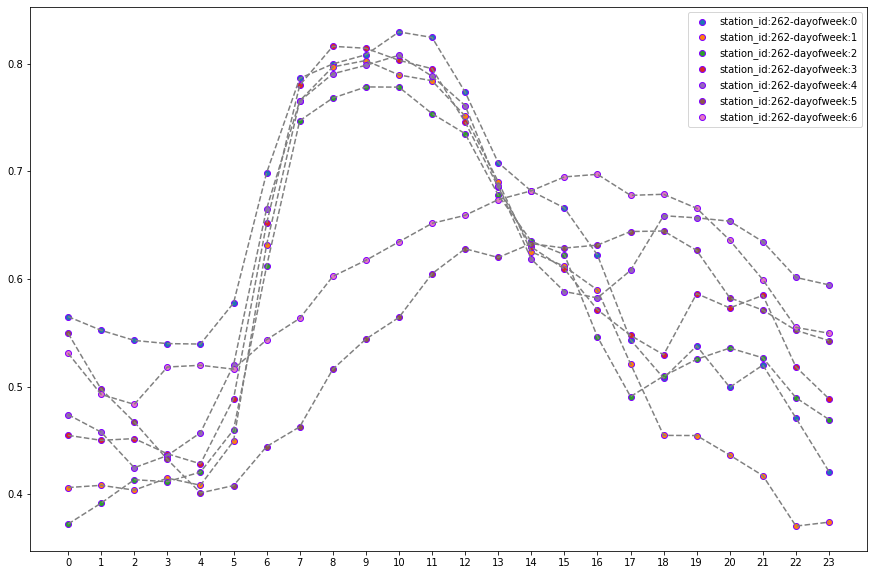

CPU times: user 5.33 s, sys: 532 ms, total: 5.86 s
Wall time: 28.5 s


In [56]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()